In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wget

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [5]:
# wget.download('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')

100% [..............................................................................] 73250 / 73250

'AER_credit_card_data.csv'

## Preparation
* Create the target variable by mapping yes to 1 and no to 0.
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.

In [7]:
df = pd.read_csv('AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [9]:
df.card = (df.card == 'yes').astype(int)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [14]:
len(df_train), len(df_val), len(df_test)

(791, 264, 264)

In [15]:
df_train.dtypes

reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [27]:
## get numerical
numerical = list(df_train.dtypes[df_train.dtypes != 'object'].index)
categorical = ['owner','selfemp']

In [25]:
roc_auc_score(df_train.reports,y_train)
# len(df_train.reports.values), len(y_train)

ValueError: multi_class must be in ('ovo', 'ovr')

In [ ]:
for var in numerical:
    df
roc_auc_score(y_val, y_pred)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [28]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\5290\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [29]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
card_decision = (y_pred >= 0.5)
(y_val == card_decision).mean()

0.9696969696969697

## Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)
* 0.615
* 0.515
* 0.715
* 0.995

In [35]:
round(roc_auc_score(y_val, y_pred), 3)

0.995

## Question 3
Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

In [40]:
scores = []

thresholds = np.arange(0, 1, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    scores.append((t, precision, recall))

In [41]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,precision,recall
0,0.00,0.799242,1.000000
1,0.01,0.861224,1.000000
2,0.02,0.875519,1.000000
3,0.03,0.901709,1.000000
4,0.04,0.905579,1.000000
...,...,...,...
95,0.95,1.000000,0.966825
96,0.96,1.000000,0.962085
97,0.97,1.000000,0.962085
98,0.98,1.000000,0.962085


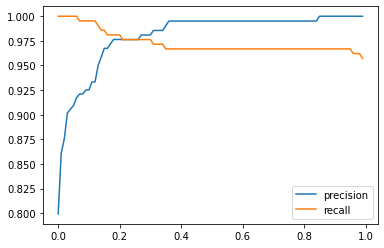

In [42]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

precision and recall curves intersect at threshold = 0.3

## Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.1
* 0.4
* 0.6
* 0.7

In [43]:
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

In [48]:
df_scores

,threshold,precision,recall,f1
0,0.00,0.799242,1.000000,0.888421
1,0.01,0.861224,1.000000,0.925439
2,0.02,0.875519,1.000000,0.933628
3,0.03,0.901709,1.000000,0.948315
4,0.04,0.905579,1.000000,0.950450
...,...,...,...,...
95,0.95,1.000000,0.966825,0.983133
96,0.96,1.000000,0.962085,0.980676
97,0.97,1.000000,0.962085,0.980676
98,0.98,1.000000,0.962085,0.980676


In [46]:
df_scores[df_scores.f1 == df_scores.f1.max()]

,threshold,precision,recall,f1
85,0.85,1.0,0.966825,0.983133
86,0.86,1.0,0.966825,0.983133
87,0.87,1.0,0.966825,0.983133
88,0.88,1.0,0.966825,0.983133
89,0.89,1.0,0.966825,0.983133
90,0.90,1.0,0.966825,0.983133
91,0.91,1.0,0.966825,0.983133
92,0.92,1.0,0.966825,0.983133
93,0.93,1.0,0.966825,0.983133
94,0.94,1.0,0.966825,0.983133


## Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

* 0.003
* 0.014
* 0.09
* 0.24

In [61]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [52]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [54]:
dv, model = train(df_train, y_train)

In [55]:
y_pred = predict(df_val, dv, model)

In [60]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


standard devidation of the AUC scores across different folds is 0.003

## Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

* 0.01
* 0.1
* 1
* 10
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [63]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.992 +- 0.006
C=0.1 0.995 +- 0.004
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003


C = 1, leads to the best mean score